# Algorithms for Big Data - Exercise 11
This lecture is focused on Generative Adversarial Networks for image generation.

A generative adversarial network (GAN) is deployed to create unique images of handwritten digits. The generated images look like they're taken from the dataset (that is the purpose), but they are generated from scratch (actually, from noise) and are all unique.

You can download the dataset from this course on [Github](https://github.com/rasvob/2020-21-ARD/tree/master/datasets)

[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-21-ARD/blob/master/abd_11.ipynb)
[Download from Github](https://github.com/rasvob/2020-21-ARD/blob/master/abd_11.ipynb)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import seaborn as sns
import tensorflow as tf
# import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize # normalization of the matrix
import scipy
import pandas as pd

tf.version.VERSION

'2.3.0'

In [2]:
import requests
from typing import List, Tuple

In [3]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

# What is GAN (Generative Adversarial Networks)?

GAN is almost always explained like the case of a counterfeiter (Generative) and the police (Discriminator). Initially, the counterfeiter will show the police a fake money. The police says it is fake. The police gives feedback to the counterfeiter why the money is fake. The counterfeiter attempts to make a new fake money based on the feedback it received. The police says the money is still fake and offers a new set of feedback. The counterfeiter attempts to make a new fake money based on the latest feedback. The cycle continues indefinitely until the police is fooled by the fake money because it looks real.

![model](https://github.com/rasvob/2020-21-ARD/raw/master/images/gan01.png)

## We will work with MNIST data in this lecture again

We will rescale the data into the [0,1] interval for easier training of the network.

In [4]:
# mnist is the basic dataset with handwritten digits
dataset = tf.keras.datasets.mnist

# data from any dataset are loaded using the load_Data function
(X_train, y_train), (X_test, y_test) = dataset.load_data()

X_train, y_train = np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test])

# Scale to <-1; 1>
X_train = (X_train.astype(np.float32) - 127.5)/127.5

# the data are in the form of 28x28 pixes with values 0-255.
print('Train data shape: ', X_train.shape, y_train.shape)

class_names = [str(x) for x in range(10)]

Train data shape:  (70000, 28, 28) (70000,)


#### Show first 25 images from the dataset

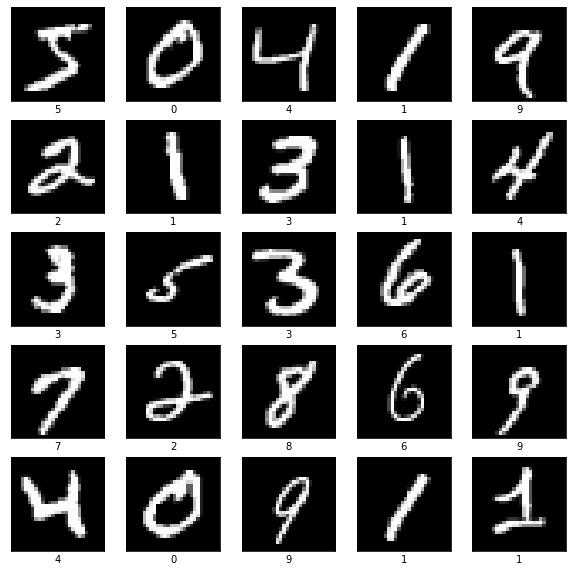

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.xlabel(class_names[y_train[i]])
plt.show()

# GAN has two main parts - Discriminator and Generator

## Discriminator
A discriminator that tells how real an image is, is basically a deep Convolutional Neural Network (CNN). 

For MNIST Dataset, the input is an image (28 pixel x 28 pixel x 1 channel). The sigmoid output is a scalar value of the probability of how real the image is (0.0 is certainly fake, 1.0 is certainly real, anything in between is a gray area). 

The difference from a typical CNN is the absence of max-pooling in between layers. Instead, a strided convolution is used for downsampling. The activation function used in each CNN layer is a leaky ReLU. A dropout between 0.4 and 0.7 between layers prevent over fitting and memorization, but it is an optional feature.

![disc](https://github.com/rasvob/2020-21-ARD/raw/master/images/gan02.png)

## Generator
The generator synthesizes fake images. The fake image is generated from a N-dimensional noise (uniform distribution between -1.0 to 1.0, gaussian noise etc.) using the inverse of convolution, called transposed convolution. 

The activation function after each layer is a LeakyReLU. The output of the sigmoid/tanh at the last layer produces the fake image.

![](https://github.com/rasvob/2020-21-ARD/raw/master/images/gan03.png)

## Adversarial Model
The adversarial model is just the generator-discriminator stacked together as shown in the figure below.

![](https://raw.githubusercontent.com/rasvob/2020-21-ARD/master/images/gan04.png)

# Training

Training is the most complex part of the GAN creation. We need to divide each batch to two halves, where one constains fake images generated by the Generator part of the network and the other contains real samples from MNIST dataset. 

It is common to disable discriminator training first and enable it only for the discriminator training phase. Afterwards it is disabled again and only the generator part of the network is trained.

There are various trick for GAN training. Very nice list is at this [repo](https://github.com/soumith/ganhacks). The most important ones in the long run are input normalization, sampling from a gaussian distribution and avoiding Sparse Gradients: ReLU, MaxPool. 

It's also possible to use label smoothing. I.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample, if it is real, then replace the label with a random number between 0.7 and 1.2, and if it is a fake sample, replace it with 0.0 and 0.3 (for example). Alternatively you can use one-sided smoothing, i.e. you use 0.7-0.9 for real samples and hard-zero for fake ones.

![](https://github.com/rasvob/2020-21-ARD/raw/master/images/gan05.png)

# We will train two models in this lecture
We will start with simle GAN in form of a fully-connected network. We will create another model basen on the CNN, called DCGAN later in the lecture.

In [7]:
# Input dimension is an important hyper-parameter
randomDim = 10

In [8]:
# We will flatten the input
X_mlp = X_train.reshape(X_train.shape[0], 28**2)

# We will create Discriminator part first

In [9]:
discriminator = keras.models.Sequential()
discriminator.add(keras.layers.Dense(1024, input_dim=28**2, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
discriminator.add(keras.layers.LeakyReLU(0.2))
discriminator.add(keras.layers.Dropout(0.3))
discriminator.add(keras.layers.Dense(512))
discriminator.add(keras.layers.LeakyReLU(0.2))
discriminator.add(keras.layers.Dropout(0.3))
discriminator.add(keras.layers.Dense(256))
discriminator.add(keras.layers.LeakyReLU(0.2))
discriminator.add(keras.layers.Dropout(0.3))
discriminator.add(keras.layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

# Now we can create the Generator part

In [10]:
generator = keras.models.Sequential()
generator.add(keras.layers.Dense(256, input_dim=randomDim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
generator.add(keras.layers.LeakyReLU(0.2))
generator.add(keras.layers.Dense(512))
generator.add(keras.layers.LeakyReLU(0.2))
generator.add(keras.layers.Dense(1024))
generator.add(keras.layers.LeakyReLU(0.2))
generator.add(keras.layers.Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               2816      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 784)              

# Combined network into one model

In [11]:
discriminator.trainable = False
ganInput = keras.layers.Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = keras.models.Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

gan.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1463312   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


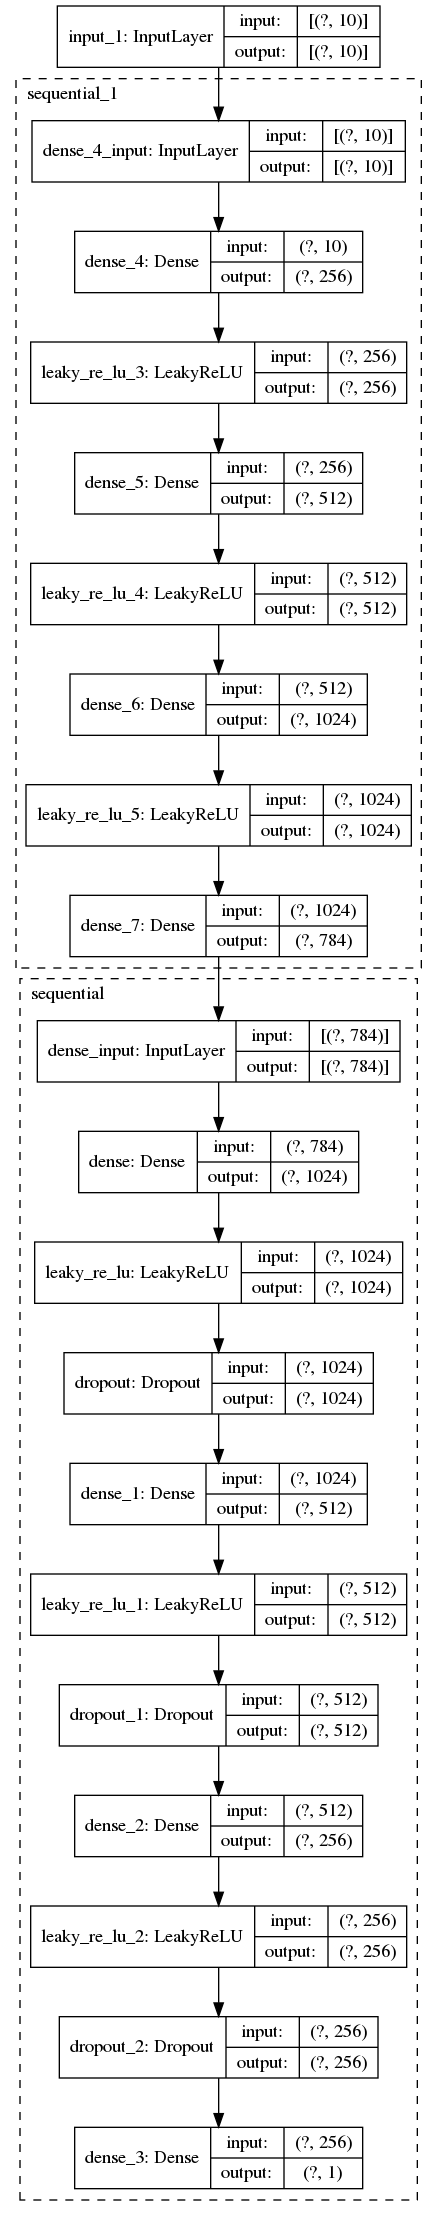

In [12]:
keras.utils.plot_model(gan, expand_nested=True, show_shapes=True)

# Now we can train the network

In [17]:
def saveModels(epoch, name='gan'):
    generator.save(f'models/{name}_generator_epoch_{epoch}')
    discriminator.save(f'models/{name}_discriminator_epoch_{epoch}')
    
from tqdm import tqdm
# from tqdm.notebook import tqdm

In [20]:
epochs=1
batchSize=128
batchCount = int(X_train.shape[0] / batchSize)
    
dLosses = []
gLosses = []

generated_images = {}
generated_examples = 100

for epoch in range(0, epochs):
    print(f'----- Epoch: {epoch} -----')
    for batch in tqdm(range(batchCount)):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batchSize, randomDim])
        imageBatch = X_mlp[np.random.randint(0, X_train.shape[0], size=batchSize)]
        
        # Generate fake MNIST images and combine them with real ones
        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])
        
        # Labels for generated and real data
        yDis = np.zeros(2*batchSize)
        # One-sided label smoothing - real ones has values 0.9
        yDis[:batchSize] = 0.9
        
        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)
        
        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize, randomDim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)
        
    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)
    
    # Save models every 20 epochs
    if epoch == 1 or epoch % 20 == 0:
        saveModels(epoch)
        noise = np.random.normal(0, 1, size=[generated_examples, randomDim])
        generatedImages = generator.predict(noise)
        generatedImages = generatedImages.reshape(generated_examples, 28, 28)
        generated_images[epoch] = generatedImages


  0%|          | 2/546 [00:00<00:28, 19.14it/s]

----- Epoch: 0 -----


100%|██████████| 546/546 [00:29<00:00, 18.55it/s]


INFO:tensorflow:Assets written to: models/gan_generator_epoch_0/assets
INFO:tensorflow:Assets written to: models/gan_discriminator_epoch_0/assets


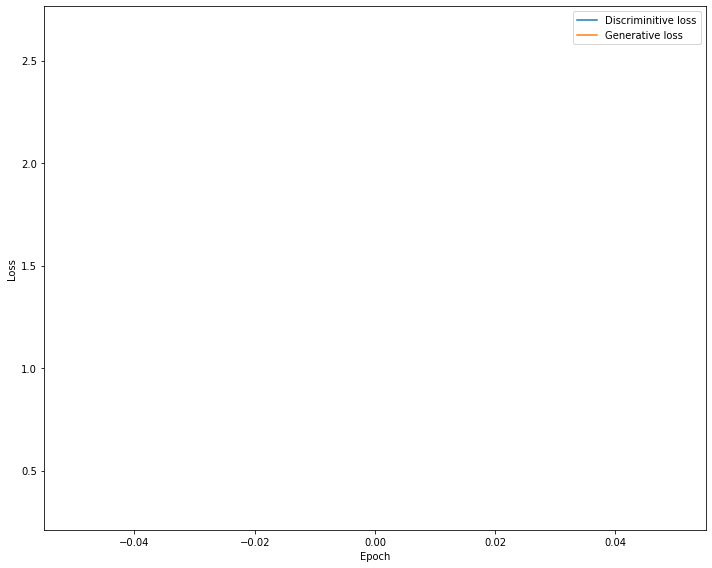

In [35]:
plt.figure(figsize=(10, 8))
plt.plot(dLosses, label='Discriminitive loss')
plt.plot(gLosses, label='Generative loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

In [23]:
# See that the epochs were saved
generated_images.keys()

dict_keys([0])

# Let's take a look at some examples generated in different epochs

In [31]:
def show_examples(epoch=0):
    selected_examples = generated_images[epoch]
    dim = (10,10)
    plt.figure(figsize=(10,10))
    for i in range(selected_examples.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(selected_examples[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()

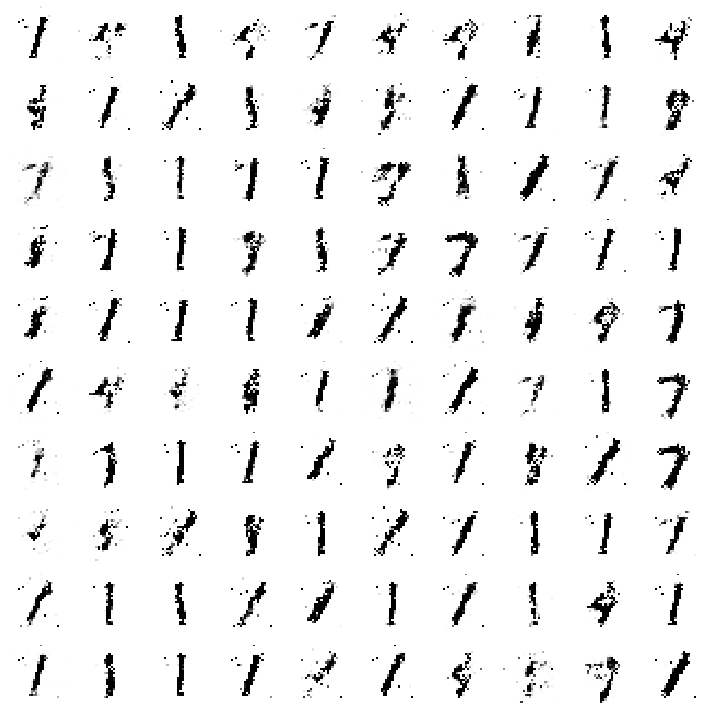

In [32]:
show_examples(0)

# Save/load TF2 API can be used to reconstruct the model identically.

A Keras model consists of multiple components:
- An architecture, or configuration, which specifies what layers the model contain, and how they're connected.
- A set of weights values (the "state of the model").
- An optimizer (defined by compiling the model).
- A set of losses and metrics (defined by compiling the model or calling add_loss() or add_metric()).

The Keras API makes it possible to save all of these pieces to disk at once, or to only selectively save some of them:
- Saving everything into a single archive in the TensorFlow SavedModel format (or in the older Keras H5 format). This is the standard practice.
- Saving the architecture / configuration only, typically as a JSON file.
- Saving the weights values only. This is generally used when training the model.

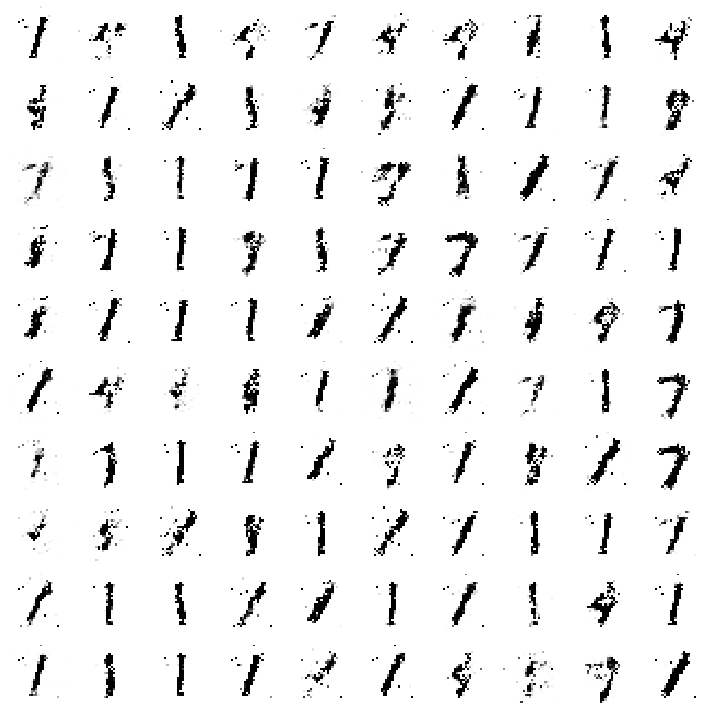

In [34]:
reconstructed_model = keras.models.load_model("models/gan_generator_epoch_0")

noise = np.random.normal(0, 1, size=[100, randomDim])
generatedImages = generator.predict(noise)
generatedImages = generatedImages.reshape(generated_examples, 28, 28)

dim = (10,10)
plt.figure(figsize=(10,10))
for i in range(selected_examples.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(selected_examples[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()